In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import os
from copy import copy

from oncotree import OncoTree, OncoNode
from util import load_result, ME_test, PR_test, to_json, to_newick, Geweke, Gelman_Rubin, disc_distance, caset_distance

In [2]:
n_tumors = [50, 100, 200, 500]
errors = [0.001, 0.01, 0.05, 0.1]
sim_name_list = ['linear', 'tree', 'mixture']
titles_list = ['A. Linear model', 'B. Single-seeded tree model', 'C. Multi-seeded tree model']
f_score = {}
prog_score = {}
prog_precission = {}
prog_recall = {}
mx_score = {}
mx_precission = {}
mx_recall = {}
epsilon = {}
delta = {}
disc = {}
caset = {}
time = {}

res_llh = {} # result likelihood per patient
star_llh = {} # star tree likelihood per patient
gen_llh = {} # generative model likelihood per patient

res_dir = 'result/synthetic'

# Analysis of all the cases

In [3]:
for sim_name in sim_name_list:
    #print('Working on %s'%sim_name)
    prog_fs = np.zeros(shape=(4,4,10), dtype=float)
    prog_precs = np.zeros(shape=(4,4,10), dtype=float) #
    prog_recs = np.zeros(shape=(4,4,10), dtype=float) #
    pfp_mat = np.zeros(shape=(4,4,10), dtype=float)
    pfn_mat = np.zeros(shape=(4,4,10), dtype=float)
    mx_fs = np.zeros(shape=(4,4,10), dtype=float)
    mx_precs = np.zeros(shape=(4,4,10), dtype=float) #
    mx_recs = np.zeros(shape=(4,4,10), dtype=float) #
    res_llh_mat = np.zeros(shape=(4,4,10), dtype=float)
    star_llh_mat = np.zeros(shape=(4,4,10), dtype=float)
    gen_llh_mat = np.zeros(shape=(4,4,10), dtype=float)
    discs_mat = np.zeros(shape=(4,4,10), dtype=float)
    casets_mat = np.zeros(shape=(4,4,10), dtype=float)
    time_mat = np.zeros(shape=(4,4,10), dtype=float)
    for i in range(4):
        for j in range(4):
            #print(j+4*i)
            n_tumor = n_tumors[i]
            error = errors[j]
            gen_file = 'data/synthetic/{}/{}.pkl'.format(sim_name, error)
            with open(gen_file, 'rb') as f:
                gen_progmo = pickle.load(f)
            for k in range(10):
                data_file = 'data/synthetic/{}/{}-{}-{}.csv'.format(sim_name, n_tumor, error, k)
                df_input = pd.read_csv(data_file, delimiter=',', index_col=0, comment='#')
                gene_names = list(df_input.columns)
                dataset = np.array(df_input, dtype=bool)
                res_file = '{}/{}/{}-{}-{}/progmo.pkl'.format(res_dir, sim_name, n_tumor, error, k)
                details_file = '{}/{}/{}-{}-{}/analysis_details.csv'.format(res_dir, sim_name, n_tumor, error, k)
                with open(res_file, 'rb') as f:
                    best_sample = pickle.load(f)
                pfp_mat[i, j, k] = best_sample.pfp
                pfn_mat[i, j, k] = best_sample.pfn
                prog_precs[i, j, k], prog_recs[i, j, k], prog_fs[i, j, k], mx_precs[i, j, k], mx_recs[i, j, k], mx_fs[i, j, k] = best_sample.compare(gen_progmo)
                discs_mat[i, j, k] = disc_distance(best_sample, gen_progmo)
                casets_mat[i, j, k] = caset_distance(best_sample, gen_progmo)
                ##### Recording the likelihoods
                gen_llh_mat[i, j, k] = (gen_progmo.likelihood(dataset)+gen_progmo.prior(power=5))/n_tumor
                with open(details_file, 'r') as f:
                    the_comments=''
                    the_lines = []
                    while True:
                        line = f.readline()
                        if not(line.startswith('#')):
                            break
                        else:
                            the_comments += line[1:]
                            the_lines.append(line[2:-2])
                            if line[2:].startswith('Analysis time: '):
                                time_mat[i, j, k] = int(line[17:-10])
                            elif line[2:].startswith('Star tree log posterior: '):
                                star_llh_mat[i, j, k] = float(line[27:-2])/n_tumor
                            elif line[2:].startswith('Best sample log posterior: '):
                                res_llh_mat[i, j, k] = float(line[29:-2])/n_tumor
                #gen_llh_mat[i, j, k] = (gen_progmo.likelihood(dataset)+gen_progmo.prior(power=5))/n_tumor
                #res_llh_mat[i, j, k] = (best_sample.likelihood(dataset)+best_sample.prior(power=5))/n_tumor
                #star_tree = OncoTree.star_from_dataset(dataset, single_error=False, error_estimation = True)
                #star_tree = star_tree.assign_error_values(dataset)
                #star_tree = star_tree.assign_f_values(dataset, fine_tuning=True)
                #star_tree,_ = star_tree.fit_error_params(dataset)
                #star_llh_mat[i, j, k] = (star_tree.likelihood(dataset)+star_tree.prior(power=5))/n_tumor
                ####
    prog_score[sim_name] = copy(prog_fs)
    prog_precission[sim_name] = copy(prog_precs)
    prog_recall[sim_name] = copy(prog_recs)
    mx_score[sim_name] = copy(mx_fs)
    mx_precission[sim_name] = copy(mx_precs)
    mx_recall[sim_name] = copy(mx_recs)
    f_score[sim_name] = np.zeros(shape=(4,4,10))
    for i in range(4):
        for j in range(4):
            for k in range(10):
                if mx_fs[i,j,k]>0 and prog_fs[i,j,k]>0:
                    f_score[sim_name][i,j,k] = 2*mx_fs[i,j,k]*prog_fs[i,j,k]/(mx_fs[i,j,k]+prog_fs[i,j,k])
    epsilon[sim_name] = copy(pfp_mat)
    delta[sim_name] = copy(pfn_mat)
    gen_llh[sim_name] = copy(gen_llh_mat)
    res_llh[sim_name] = copy(res_llh_mat)
    star_llh[sim_name] = copy(star_llh_mat)
    disc[sim_name] = copy(discs_mat)
    caset[sim_name] = copy(casets_mat)
    time[sim_name] = copy(time_mat)

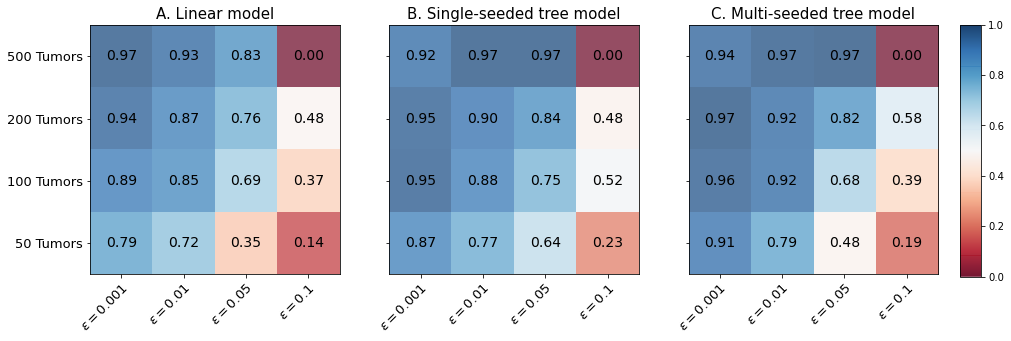

In [4]:
### PLOTTING F_SCORES ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    mean_matrix = np.mean(f_score[sim_name], axis=2)
    im = axes[w].imshow(mean_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%(mean_matrix[_i, _j]),
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/f_overall.pdf',format='pdf')

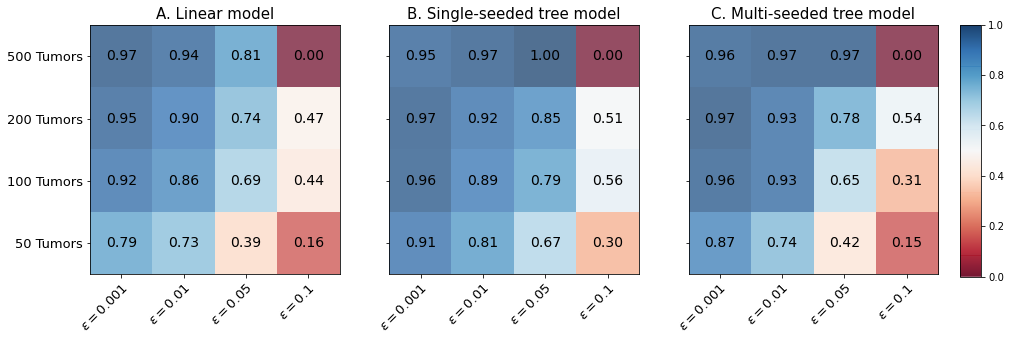

In [5]:
### PLOTTING F_PR_SCORES ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    mean_matrix = np.mean(prog_score[sim_name], axis=2)
    im = axes[w].imshow(mean_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%(mean_matrix[_i, _j]),
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/f_pr.pdf',format='pdf')

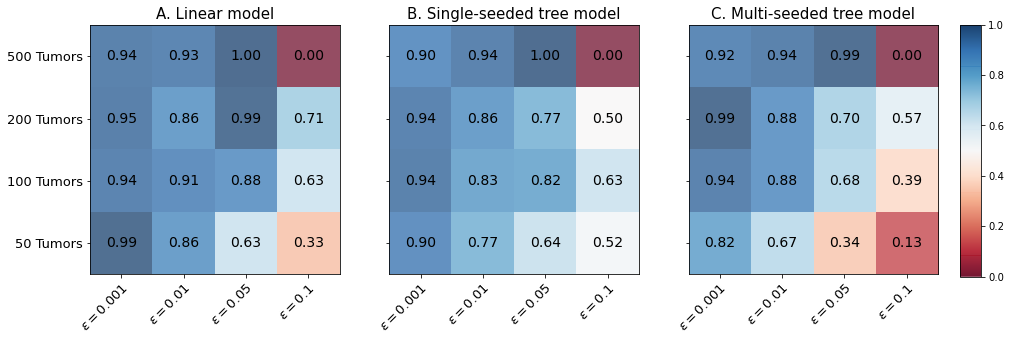

In [6]:
### PLOTTING precission_PR_SCORES ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    mean_matrix = np.mean(prog_precission[sim_name], axis=2)
    im = axes[w].imshow(mean_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%(mean_matrix[_i, _j]),
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/precission_pr.pdf',format='pdf')

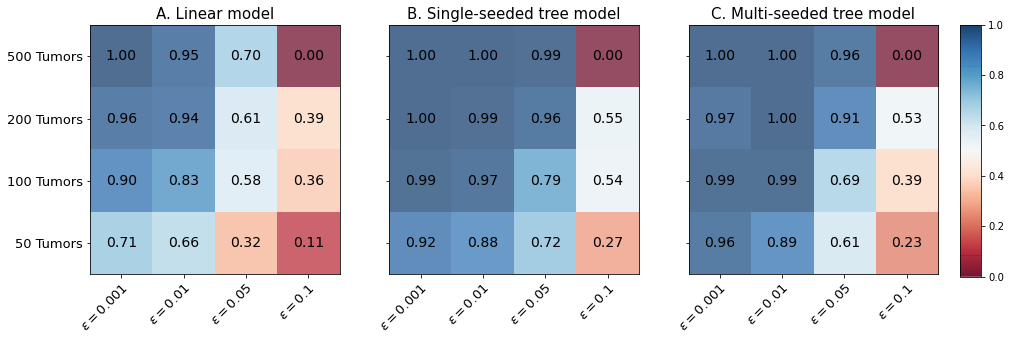

In [7]:
### PLOTTING recall_PR_SCORES ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    mean_matrix = np.mean(prog_recall[sim_name], axis=2)
    im = axes[w].imshow(mean_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%(mean_matrix[_i, _j]),
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/recall_pr.pdf',format='pdf')

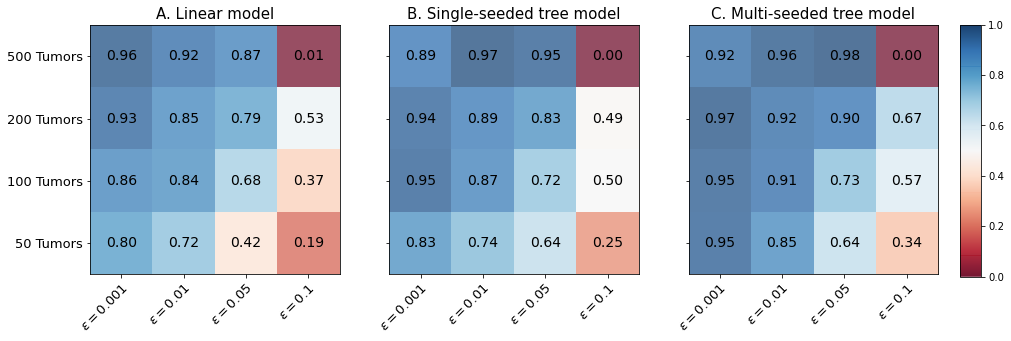

In [8]:
### PLOTTING F_MX_SCORES ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    mean_matrix = np.mean(mx_score[sim_name], axis=2)
    im = axes[w].imshow(mean_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%(mean_matrix[_i, _j]),
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/f_mx.pdf',format='pdf')

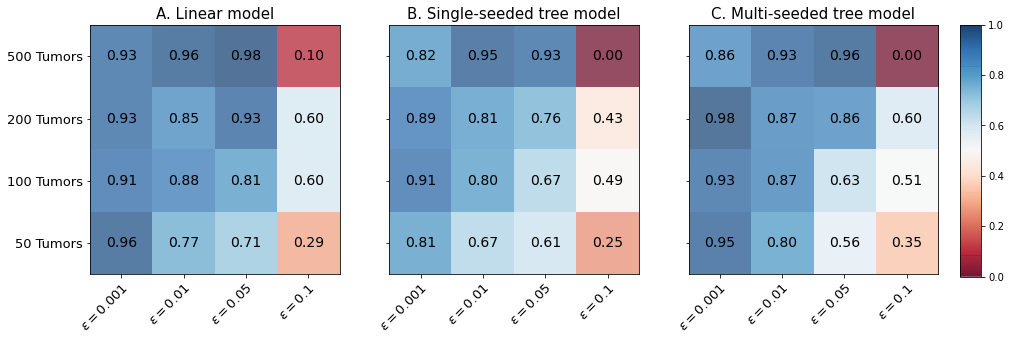

In [9]:
### PLOTTING precission_MX_SCORES ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    mean_matrix = np.mean(mx_precission[sim_name], axis=2)
    im = axes[w].imshow(mean_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%(mean_matrix[_i, _j]),
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/precission_mx.pdf',format='pdf')

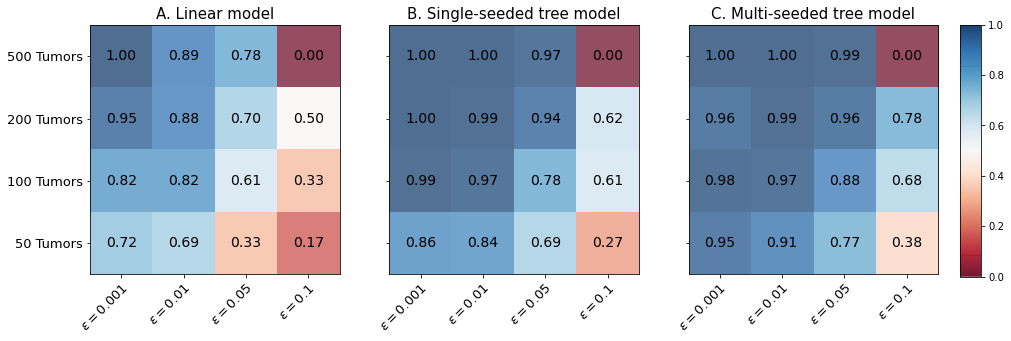

In [10]:
### PLOTTING recall_MX_SCORES ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    mean_matrix = np.mean(mx_recall[sim_name], axis=2)
    im = axes[w].imshow(mean_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%(mean_matrix[_i, _j]),
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/recall_mx.pdf',format='pdf')

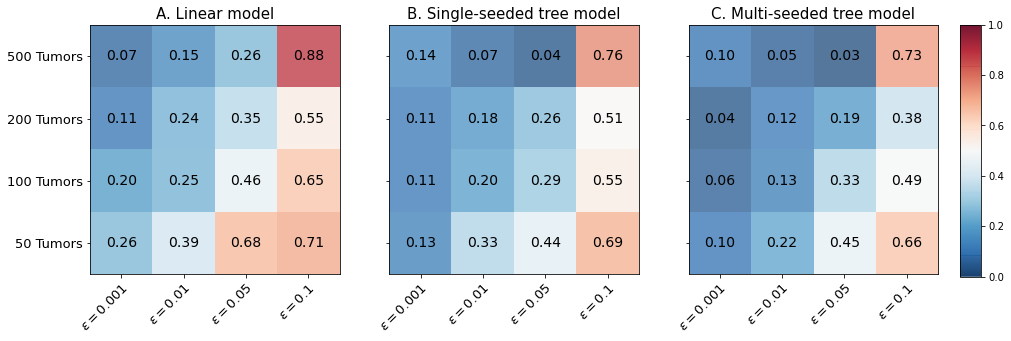

In [11]:
### PLOTTING Disc ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    the_matrix = np.mean(disc[sim_name], axis=2)
    im = axes[w].imshow(the_matrix, origin='lower', cmap='RdBu_r', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%the_matrix[_i, _j],
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/disc.pdf',format='pdf')

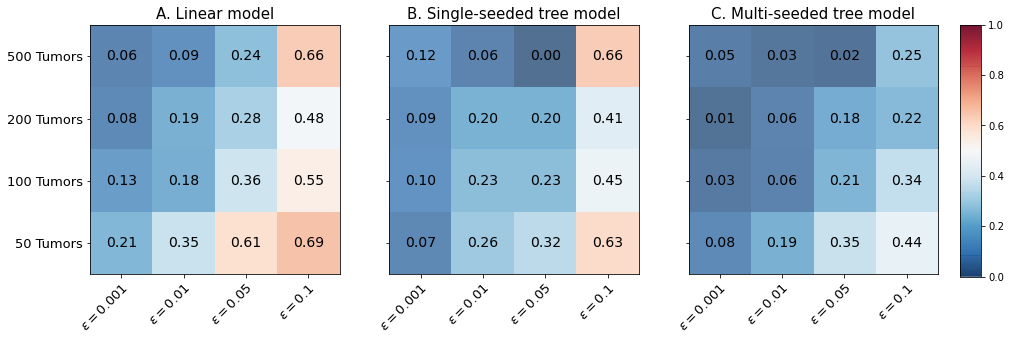

In [12]:
### PLOTTING Caset ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    the_matrix = np.mean(caset[sim_name], axis=2)
    im = axes[w].imshow(the_matrix, origin='lower', cmap='RdBu_r', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%the_matrix[_i, _j],
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/caset.pdf',format='pdf')

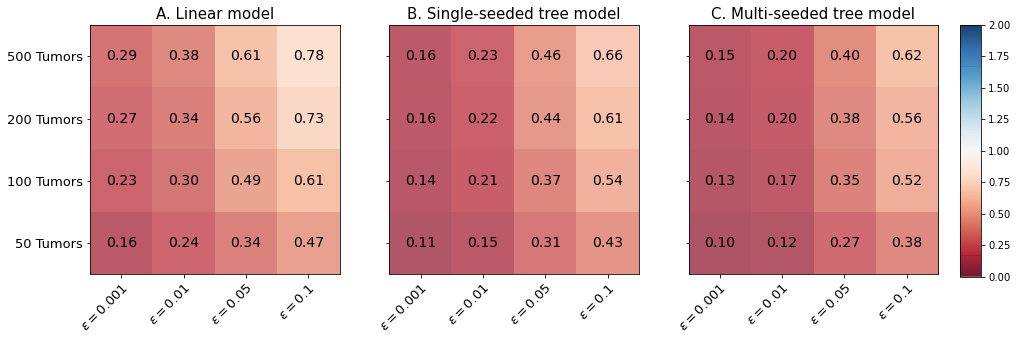

In [13]:
### PLOTTING p(star)/p(gen) ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    the_matrix = np.mean(np.exp(star_llh[sim_name]-gen_llh[sim_name]), axis=2)
    im = axes[w].imshow(the_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=2, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%the_matrix[_i, _j],
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/post_star2gen.pdf',format='pdf')

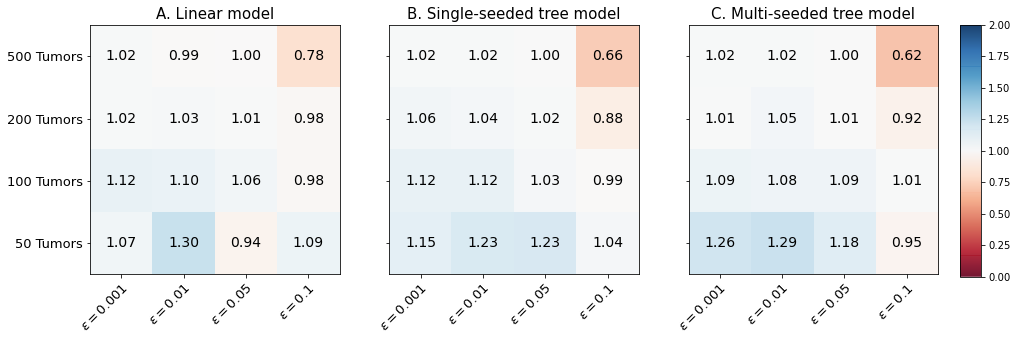

In [14]:
### PLOTTING p(res)/p(gen) ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    the_matrix = np.mean(np.exp(res_llh[sim_name]-gen_llh[sim_name]), axis=2)
    im = axes[w].imshow(the_matrix, origin='lower', cmap='RdBu', vmin=0, vmax=2, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%the_matrix[_i, _j],
                           ha="center", va="center", color="k", fontsize=14)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/post_res2gen.pdf',format='pdf')

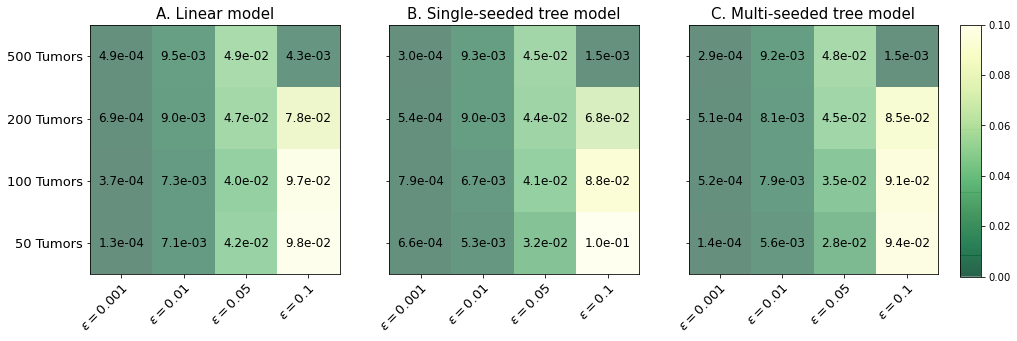

In [15]:
### PLOTTING EPSILON ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']

for w, sim_name in enumerate(sim_name_list):
    the_matrix = np.mean(epsilon[sim_name],axis=2)
    im = axes[w].imshow(the_matrix, origin='lower', cmap='YlGn_r', vmin=0, vmax=0.1, alpha=0.6)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.1e'%the_matrix[_i, _j],
                           ha="center", va="center", color="k", fontsize=12)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/epsilon.pdf',format='pdf')

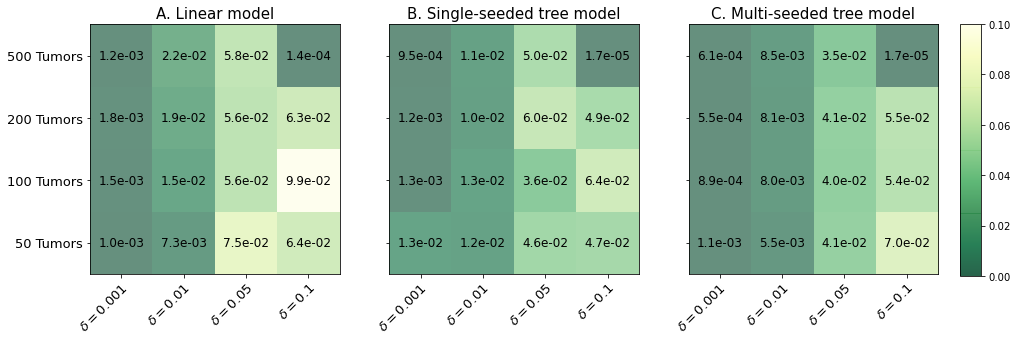

In [16]:
### PLOTTING DELTA ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\delta=0.001$', r'$\delta=0.01$', r'$\delta=0.05$',
           r'$\delta=0.1$']

for w, sim_name in enumerate(sim_name_list):
    the_matrix = np.mean(delta[sim_name], axis=2)
    im = axes[w].imshow(the_matrix, origin='lower', cmap='YlGn_r', vmin=0, vmax=0.1, alpha=0.6)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.1e'%the_matrix[_i, _j],
                           ha="center", va="center", color="k", fontsize=12)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/delta.pdf',format='pdf')

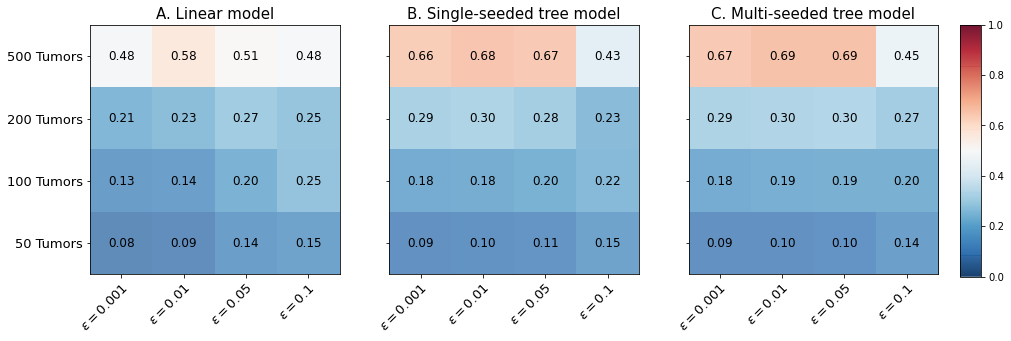

In [17]:
### PLOTTING TIMEX ###

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
row_label = ["50 Tumors", "100 Tumors", "200 Tumors", "500 Tumors"]
col_label = [r'$\epsilon=0.001$', r'$\epsilon=0.01$', r'$\epsilon=0.05$',
           r'$\epsilon=0.1$']
for w, sim_name in enumerate(sim_name_list):
    mean_matrix = np.mean(time[sim_name], axis=2)/100000
    im = axes[w].imshow(mean_matrix, origin='lower', cmap='RdBu_r', vmin=0, vmax=1, alpha=0.7)
    # We want to show all ticks...
    axes[w].set_xticks(np.arange(len(col_label)))
    axes[w].set_yticks(np.arange(len(row_label)))
    # ... and label them with the respective list entries
    axes[w].set_xticklabels(col_label, fontsize=13)
    axes[w].set_yticklabels(row_label, fontsize=13)
    # Rotate the tick labels and set their alignment.
    plt.setp(axes[w].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for _i in range(len(row_label)):
        for _j in range(len(col_label)):
            text = axes[w].text(_j, _i, '%.2f'%(mean_matrix[_i, _j]),
                           ha="center", va="center", color="k", fontsize=12)
    axes[w].set_title(titles_list[w], fontsize=15)
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/synthetic_data_experiments/syn_time.pdf',format='pdf')